In [2]:
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import scipy as sp
import scipy.integrate as spi
import scipy.linalg as spl
from scipy import interpolate
import matplotlib.pyplot as plt
import ujson
from sympy.physics.quantum import TensorProduct

def tensor_product(A, B):
    return TensorProduct(A, B)

def trace_distance(A, B):
    return 0.5 * np.trace(spl.sqrtm(((A - B).T @ (A - B))))

# Two sided-operator

In [4]:
def twosided_super_operator(H1, H2, Ls1_list, Ls2_list):
    dim, _ = H1.shape
    jump_op_num = len(Ls1_list)
    
    if len(Ls1_list) != len(Ls2_list):
        raise ValueError('The number of jump operators does not match')
    
    tmp = -1.0j*(tensor_product(np.eye(dim), H1) - tensor_product(H2.T, np.eye(dim)))
    
    for c in range(jump_op_num):
        L1 = Ls1_list[c]
        L2 = Ls2_list[c]
        tmp += tensor_product(L2.conj(), L1)
        tmp += -1/2 * tensor_product(np.eye(dim), (L1.conj().T @ L1))
        tmp += -1/2 * tensor_product((L2.conj().T @ L2).T, np.eye(dim))
        
    return tmp

def twosided_nsolve(super_op, rho_init, t):
    s, _ = rho_init.shape
    rho_init_vec = np.array(rho_init).T.flatten()
    tmp2 = (spl.expm(super_op * t) @ rho_init_vec).reshape(s, s).T
    return np.matrix(tmp2)

In [5]:
def QFI_direct(rho_init, H, L, t, tau, eps_ratio = 10**(-3)):
    eps = np.min([t * eps_ratio, 0.01])
    t1 = t
    t2 = t + eps

    H1 = t1/tau*H
    H2 = t2/tau*H
    L1 = np.sqrt(t1/tau)*L
    L2 = np.sqrt(t2/tau)*L
    sop = twosided_super_operator(H1, H2, [L1], [L2])
#     tmp_mat =  twosided_nsolve(sop, rho_init, t)
    tmp_mat =  twosided_nsolve(sop, rho_init, tau)

    return 8 / eps**2 * (1 - np.abs(np.trace(tmp_mat)))

# LHS
$$
qactivity\_integral = \frac{1}{2}\int_{0}^{\tau}dt\,\frac{\sqrt{\mathcal{B}(t)}}{t}
$$

In [6]:
def qactivity_integral(rho_init, H, L, tau, eps_ratio = 10**(-3), start_time = 10**(-5)):
    tmp = spi.quad(lambda t: np.sqrt(QFI_direct(rho_init, H, L, t, tau, eps_ratio = eps_ratio)), start_time, tau)[0]
    return 0.5 * tmp

def qactivity_integral_interp(rho_init, H, L, tau, interp_maxtime, divnum = 300, eps_ratio = 10**(-3), start_time = 10**(-5)):
    tslot = [_t for _t in np.linspace(start_time, interp_maxtime, num=divnum)]
    qfi_vals = [QFI_direct(rho_init, H, L, _t, tau, eps_ratio = eps_ratio) for _t in tslot]
    f = interpolate.interp1d(tslot, qfi_vals)
    tmp = spi.quad(lambda t: np.sqrt(f(t)), start_time, tau)[0]
    return 0.5 * tmp

def qactivity_direct(rho_init, H, L, tau, eps_ratio = 10**(-3)):
    return tau**2 * QFI_direct(rho_init, H, L, tau, tau, eps_ratio = eps_ratio)

## RHS
$$
\mathcal{L}_{D}\left(\rho_{1},\rho_{2}\right)\equiv\arccos\left[\sqrt{\mathrm{Fid}\left(\rho_{1},\rho_{2}\right)}\right]
$$
$$
\mathrm{Fid}\left(\rho_{1},\rho_{2}\right)\equiv\left(\mathrm{Tr}\sqrt{\sqrt{\rho_{1}}\rho_{2}\sqrt{\rho_{2}}}\right)^{2}
$$

In [9]:
def Fid2(rho, sigma):
    tmp = (spl.sqrtm(spl.sqrtm(rho) @ sigma @ spl.sqrtm(rho))).trace()
    return abs(tmp**2)

def L_D2(rho_init, rho_end):
    return np.arccos(np.sqrt(Fid2(rho_init, rho_end)))

# Calculations

In [14]:
# Rabi oscillation model
ev = np.matrix([[0],[1]])
gv = np.matrix([[1],[0]])

Delta = 1
Omega = 1
kappa = 2.0

H = Delta * ev @ ev.conj().T + 0.5 * Omega * (ev @ gv.conj().T + gv @ ev.conj().T)
L = np.sqrt(kappa) * gv @ ev.conj().T

In [15]:
rho_init = np.array([[1, 0], [0, 0]], dtype=complex)

lindblad_sop = twosided_super_operator(H, H, [L], [L])
rho_t = lambda t: twosided_nsolve(lindblad_sop, rho_init, t)

In [16]:
max_time = 10.0
# tslot = np.linspace(0.01, max_time, num = 200)
tslot = np.arange(0.05, 10.0 + 10E-3, 0.05)
interp_max_time = max_time * 3
r = [(qactivity_integral_interp(rho_init, H, L, _t, _t*1.1), L_D2(rho_t(0.0), rho_t(_t))) \
     for _t in tslot]

/tmp/ipykernel_1321/1199941692.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  tmp = spi.quad(lambda t: np.sqrt(f(t)), start_time, tau)[0]
/tmp/ipykernel_1321/1199941692.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tmp = spi.quad(lambda t: np.sqrt(f(t)), start_time, tau)[0]


(0.0, 2.0)

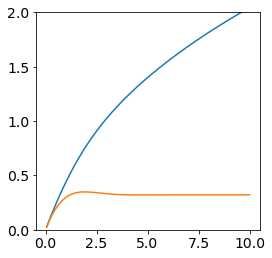

In [17]:
plt.rcParams["figure.figsize"] = (4, 4)
# plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 14
xvals = np.array(r)[:, 0]
yvals = np.array(r)[:, 1]
time_slot = tslot
plt.plot(time_slot, xvals)
plt.plot(time_slot, yvals)
plt.ylim(0, 2)

In [29]:
tmp_m = np.array([time_slot, xvals, yvals]).T
tmp_m = np.vstack([[0,0,0], tmp_m])
np.savetxt(f'/<output_folder>/QSLfixed_teolve_Delta_{Delta}_Omega_{Omega}_kappa_{kappa}.txt', tmp_m)